In [1]:
#new cluster sim

from cluster_g import *
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

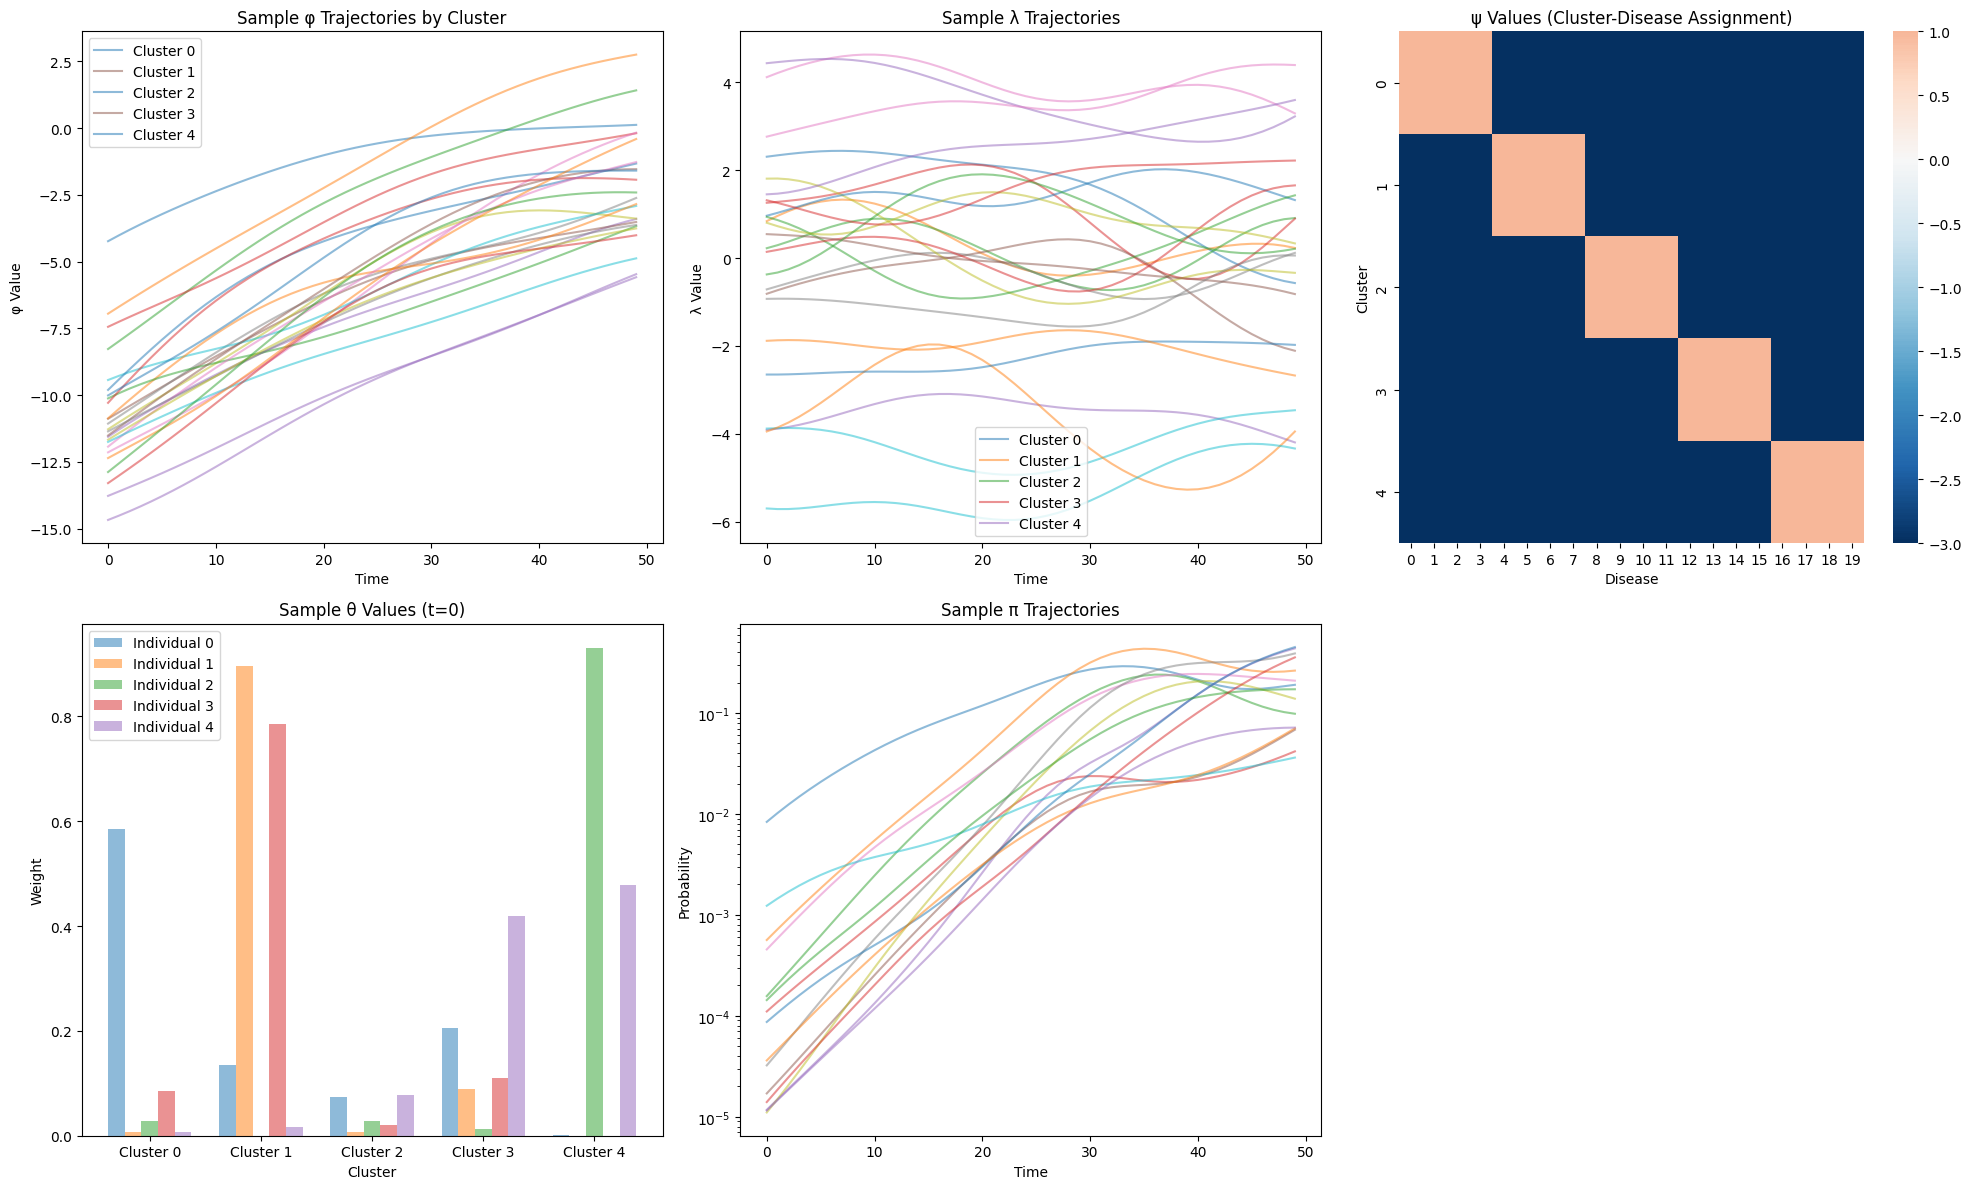

In [27]:
def plot_synthetic_components(data, num_samples=5):
    plt.figure(figsize=(20, 12))
    
    # 1. Plot sample phi trajectories for each cluster
    plt.subplot(231)
    for k in range(data['phi'].shape[0]):  # For each cluster
        for d in range(min(num_samples, data['phi'].shape[1])):  # Sample diseases
            plt.plot(data['phi'][k,d,:], alpha=0.5, label=f'Cluster {k}' if d==0 else '')
    plt.title('Sample φ Trajectories by Cluster')
    plt.xlabel('Time')
    plt.ylabel('φ Value')
    plt.legend()
    
    # 2. Plot sample lambda trajectories
    plt.subplot(232)
    for i in range(min(num_samples, data['lambda'].shape[0])):  # Sample individuals
        for k in range(data['lambda'].shape[1]):  # For each cluster
            plt.plot(data['lambda'][i,k,:], alpha=0.5, label=f'Cluster {k}' if i==0 else '')
    plt.title('Sample λ Trajectories')
    plt.xlabel('Time')
    plt.ylabel('λ Value')
    plt.legend()
    
    # 3. Plot psi heatmap
    plt.subplot(233)
    sns.heatmap(data['psi'], cmap='RdBu_r', center=0)
    plt.title('ψ Values (Cluster-Disease Assignment)')
    plt.xlabel('Disease')
    plt.ylabel('Cluster')
    
     # 4. Plot sample theta (signature weights) as bars instead of lines
    plt.subplot(234)
    width = 0.15  # Width of bars
    x = np.arange(data['theta'].shape[1])  # Cluster indices
    
    for i in range(min(num_samples, data['theta'].shape[0])):
        plt.bar(x + i*width, data['theta'][i,:,0], 
               width, alpha=0.5, label=f'Individual {i}')
    
    plt.title('Sample θ Values (t=0)')
    plt.xlabel('Cluster')
    plt.ylabel('Weight')
    plt.legend()
    plt.xticks(x + width*2, [f'Cluster {i}' for i in x])
    
    # 5. Plot sample pi trajectories
    plt.subplot(235)
    for i in range(min(num_samples, data['pi'].shape[0])):
        for d in range(min(3, data['pi'].shape[1])):
            plt.plot(data['pi'][i,d,:], alpha=0.5, label=f'Ind {i}, Disease {d}' if i==0 else '')
    plt.title('Sample π Trajectories')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# Generate and plot
np.random.seed(42)
data = generate_clustered_survival_data(N=1000, D=20, T=50, K=5, P=5)
plot_synthetic_components(data)

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 45214952.00
Phi kernel condition number: 104912536.00

Cluster Sizes:
Cluster 0: 4 diseases
Cluster 1: 4 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 5 diseases
Initialization complete!


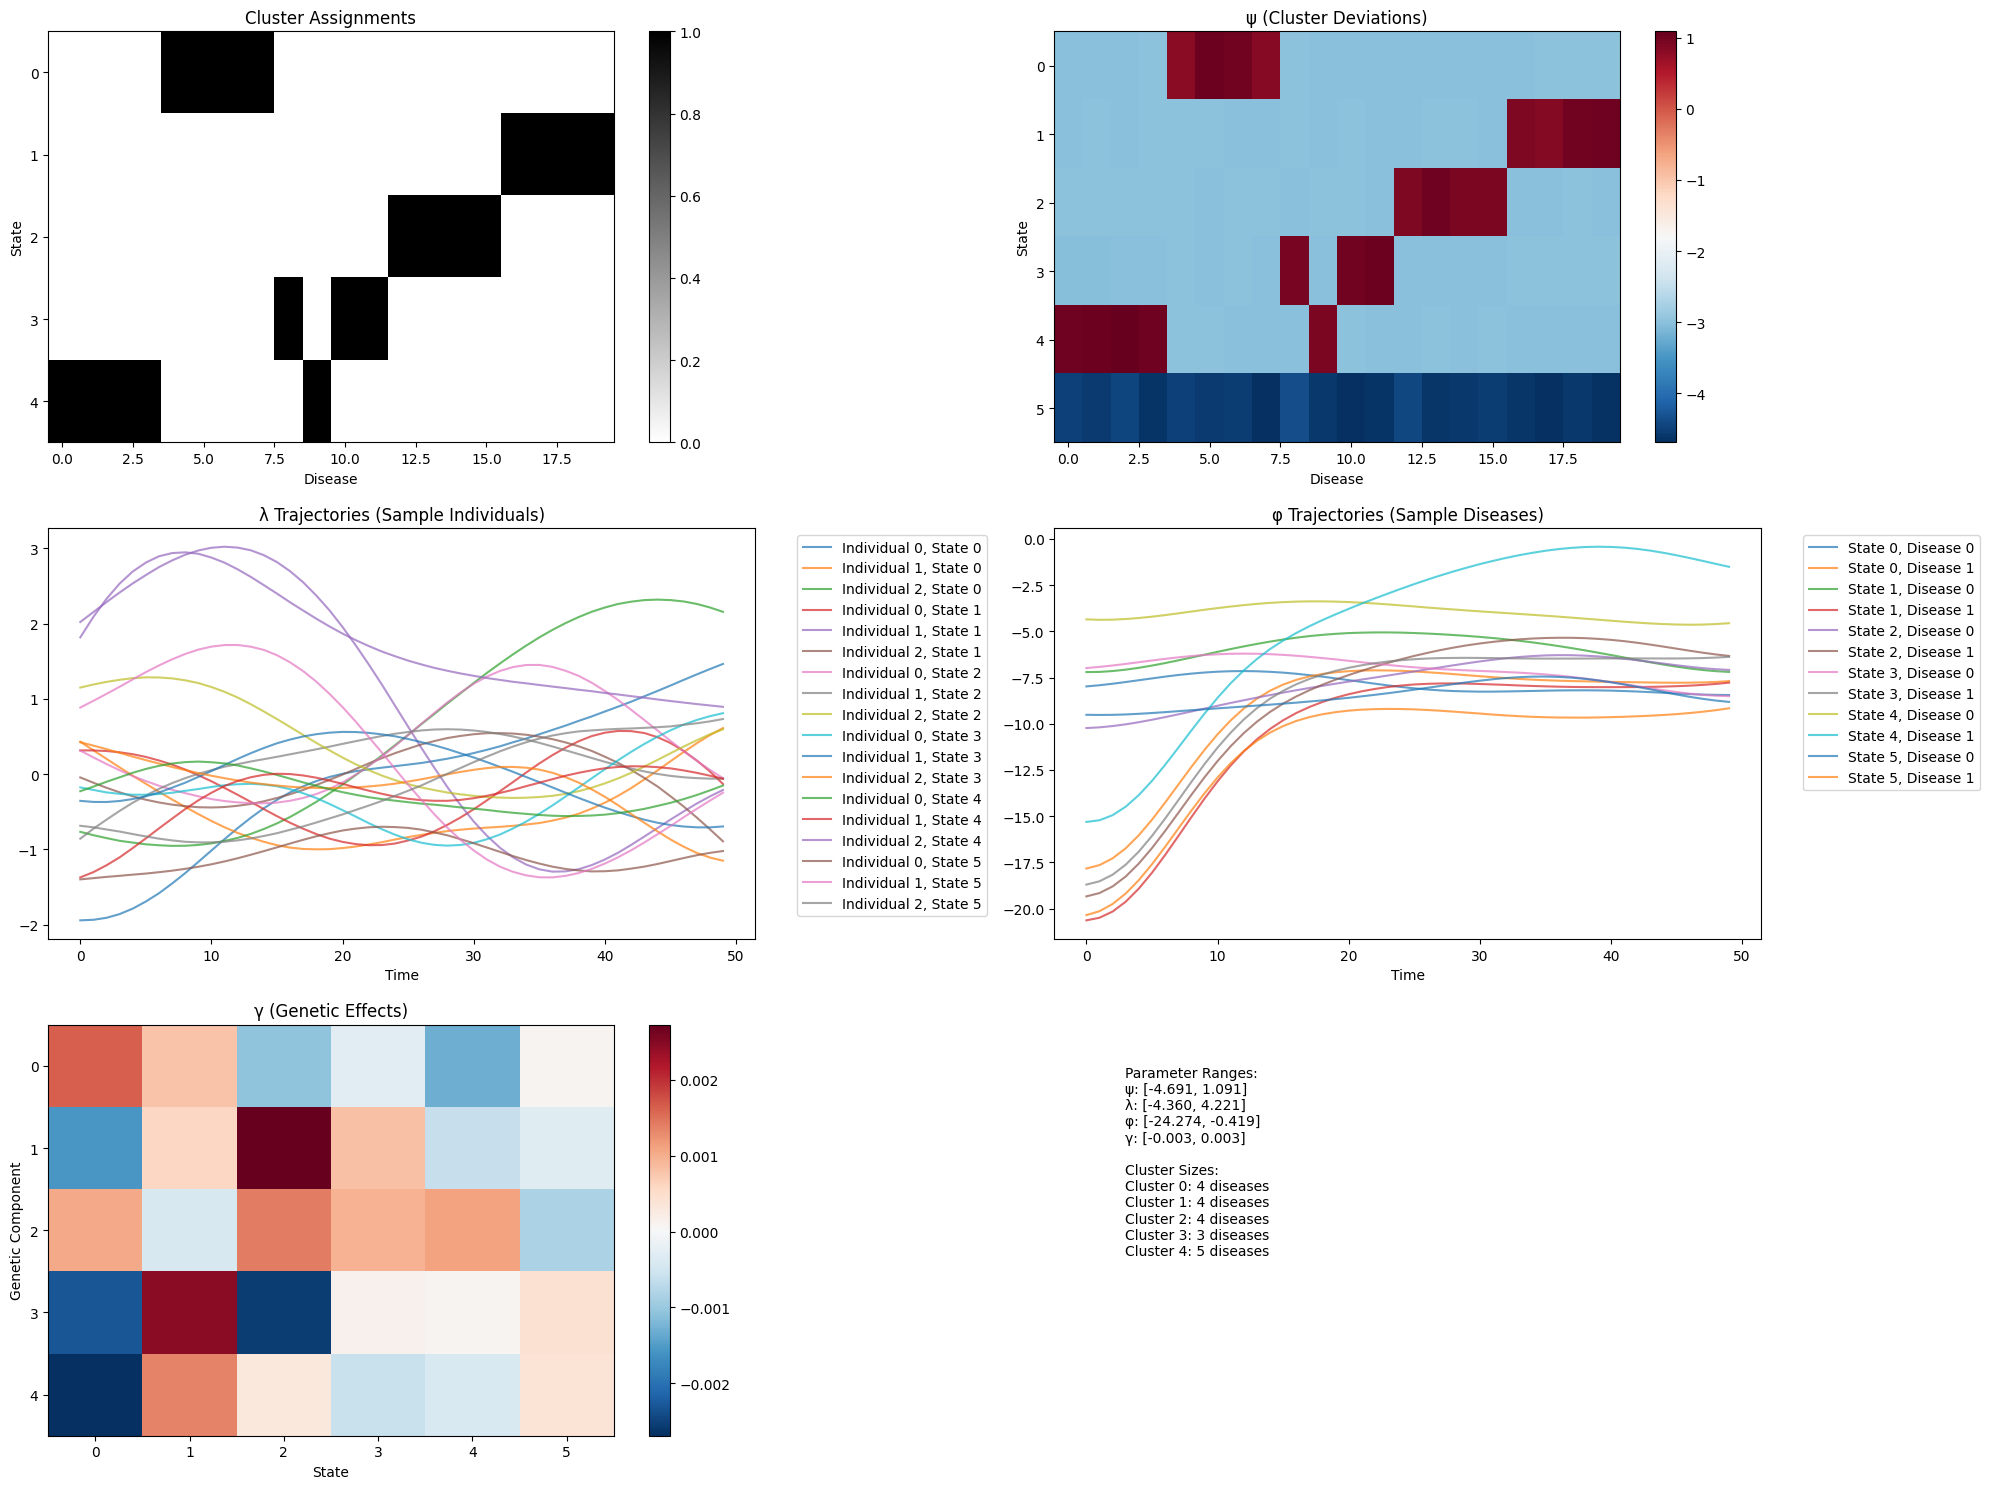

In [30]:
# First generate synthetic data
np.random.seed(42)
data = generate_clustered_survival_data(N=1000, D=20, T=50, K=5, P=5)

# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals

# Initialize model with synthetic data
model = AladynSurvivalFixedKernelsAvgLoss_clust(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0]+1,  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,              # Added Y_tensor
    prevalence_t=prevalence_t
)

model.visualize_initialization()


Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 364.7393
Psi gradient stats:
Mean: -1.2951e-02
Std:  8.3729e-02
Max:  1.6347e-01
Min:  -2.5263e-01
Average psi change: 9.9957e-05
Epoch 0, Loss: 364.7393, Gradients - Lambda: 4.667e+00, Phi: 1.817e+02, Gamma: 1.219e-01, Psi: 2.526e-01

Epoch 1
Loss: 286.6001
Psi gradient stats:
Mean: -1.3001e-02
Std:  8.3564e-02
Max:  1.6225e-01
Min:  -2.5409e-01
Average psi change: 9.9405e-05
Epoch 1, Loss: 286.6001, Gradients - Lambda: 4.279e+00, Phi: 1.676e+02, Gamma: 1.191e-01, Psi: 2.541e-01

Estimated total training time: 8.0 minutes

Epoch 2
Loss: 230.7830
Psi gradient stats:
Mean: -1.3047e-02
Std:  8.3352e-02
Max:  1.6077e-01
Min:  -2.5421e-01
Average psi change: 9.9080e-05
Epoch 2, Loss: 230.7830, Gradients - Lambda: 3.884e+00, Phi: 1.542e+02, Gamma: 1.166e-01, Psi: 2.542e-01

Epoch 3
Loss: 192.5559
Psi gradient stats:
Mean: -1.3091e-02
Std:  8.3132e-02
Max:  1.5909e-01
Min:  -2.5460e-01
Average psi change: 9.8550e-05
Epoch 3, Loss: 192.5559, Gradients - Lambda: 3.496e+00, Phi: 

ValueError: operands could not be broadcast together with shapes (6,20) (5,20) 

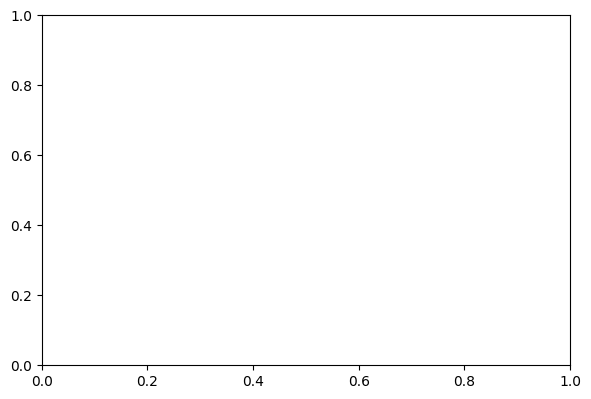

In [31]:

K=6
# Store initial psi values
initial_psi = model.psi.detach().clone()

# Fit the model
history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)


In [32]:
model.K

6

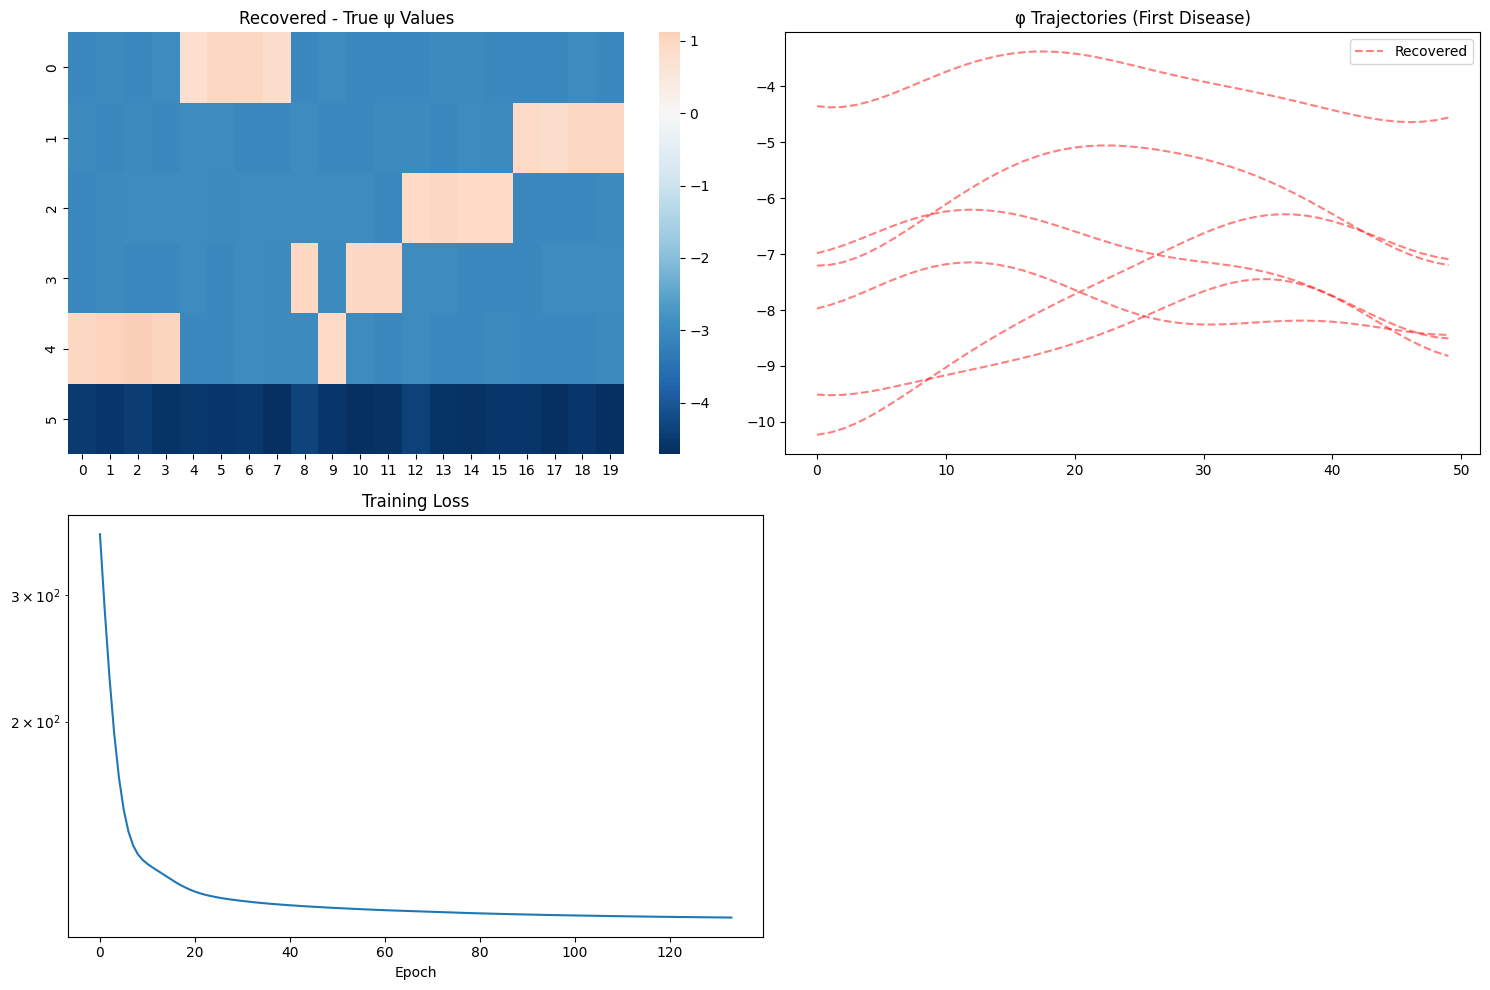


Overall psi changes:
0.023698946461081505


In [35]:

# Compare recovered vs true parameters
def compare_parameters(model, true_data):
    plt.figure(figsize=(15, 10))
    
    # 1. Compare psi values
    plt.subplot(221)
    sns.heatmap(model.psi.detach().numpy(), 
                cmap='RdBu_r', center=0)
    plt.title('Recovered - True ψ Values')
    
    # 2. Compare phi trajectories
    plt.subplot(222)
    recovered_phi = model.phi.detach().numpy()
    for k in range(K):
        #plt.plot(true_data['phi'][k,0,:], 'b-', alpha=0.5, label='True' if k==0 else '')
        plt.plot(recovered_phi[k,0,:], 'r--', alpha=0.5, label='Recovered' if k==0 else '')
    plt.title('φ Trajectories (First Disease)')
    plt.legend()
    
    # 3. Training history
    plt.subplot(223)
    plt.plot(history['loss'])
    plt.yscale('log')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()

# Compare results
compare_parameters(model, data)

print("\nOverall psi changes:")
print(torch.abs(model.psi - initial_psi).mean().item())

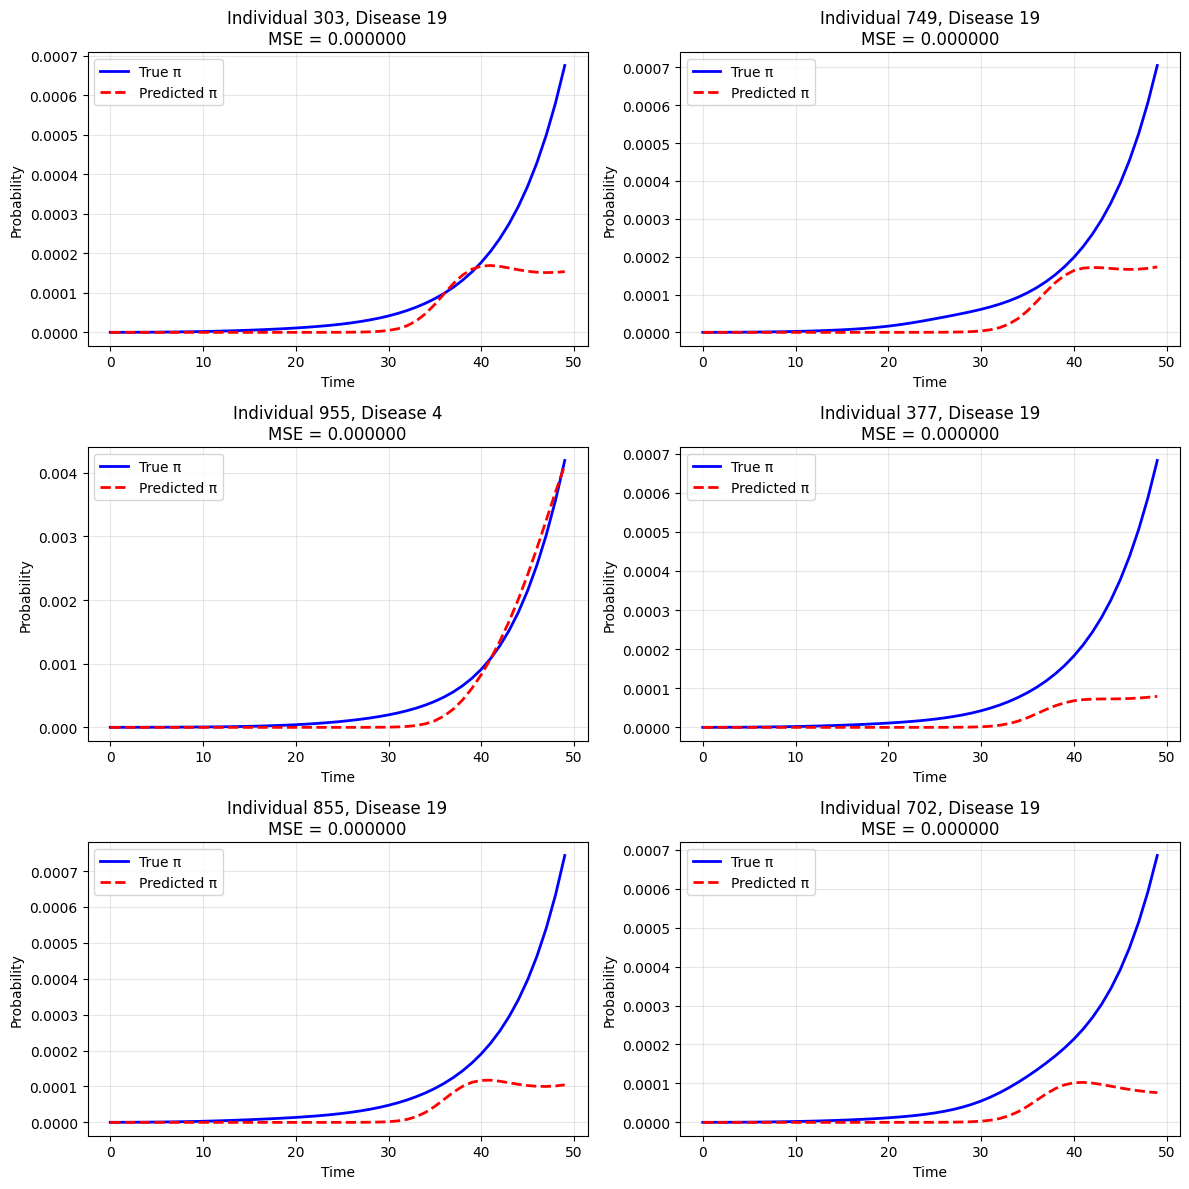

In [36]:
plot_best_matches(data['pi'], model.forward()[0], n_samples=6)

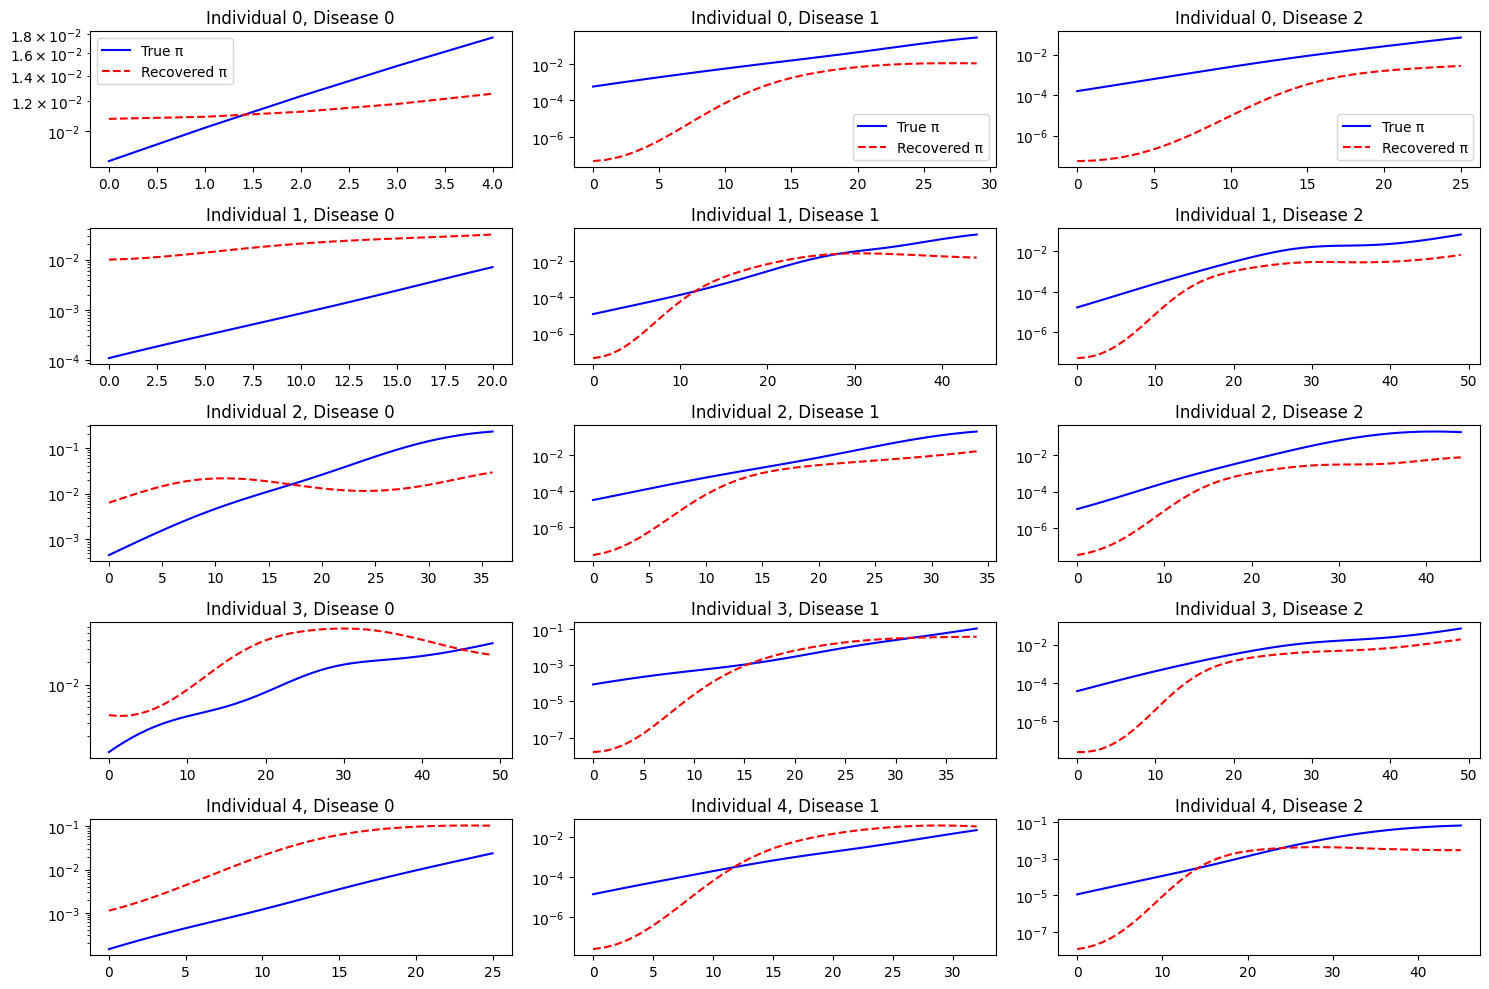

In [20]:
def compare_pi_predictions(model, true_data, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    # Get predicted pi
    with torch.no_grad():
        pred_pi = model.forward()[0].cpu().numpy()
    
    # Compare for individuals still at risk
    for n in range(num_samples):
        for d in range(min(3, true_data['Y'].shape[1])):  # First few diseases
            # Get times where individual is still at risk
            at_risk_times = np.where(true_data['Y'][n,d,:].cumsum() == 0)[0]
            
            if len(at_risk_times) > 0:
                plt.subplot(num_samples, 3, n*3 + d + 1)
                plt.plot(at_risk_times, true_data['pi'][n,d,at_risk_times], 'b-', label='True π')
                plt.plot(at_risk_times, pred_pi[n,d,at_risk_times], 'r--', label='Recovered π')
                plt.yscale('log')
                plt.title(f'Individual {n}, Disease {d}')
                if n == 0:
                    plt.legend()
    
    plt.tight_layout()
    plt.show()

def compare_pi_predictions(model, true_data, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    # Get predicted pi
    with torch.no_grad():
        pred_pi = model.forward()[0].cpu().numpy()
    
    # Compare for individuals still at risk
    for n in range(num_samples):
        for d in range(min(3, true_data['Y'].shape[1])):  # First few diseases
            # Get times where individual is still at risk
            at_risk_times = np.where(true_data['Y'][n,d,:].cumsum() == 0)[0]
            
            if len(at_risk_times) > 0:
                plt.subplot(num_samples, 3, n*3 + d + 1)
                plt.plot(at_risk_times, true_data['pi'][n,d,at_risk_times], 'b-', label='True π')
                plt.plot(at_risk_times, pred_pi[n,d,at_risk_times], 'r--', label='Recovered π')
                plt.yscale('log')
                plt.title(f'Individual {n}, Disease {d}')
                if n == 0:
                    plt.legend()
    
    plt.tight_layout()
    plt.show()


compare_pi_predictions(model,data,num_samples=5)



In [16]:
print("Number of events per disease:")
print(data['Y'].sum(axis=(0,2)))  # Sum over individuals and time

print("\nNumber of events per time point:")
print(data['Y'].sum(axis=(0,1)))  # Sum over individuals and diseases

Number of events per disease:
[ 3. 94. 20. 23.  1.  2.  0. 91. 13.  9.  2. 64.  8.  0.  1.  3.  5.  3.
  0.  3.]

Number of events per time point:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  1.  1.  2.  2.  1.  0.  2.  1.  4.  1.  1.  1.  2.  4.  3.  8.  6.
  7.  9.  3. 12. 14. 18. 18. 19. 25. 24. 33. 39. 44. 38.]


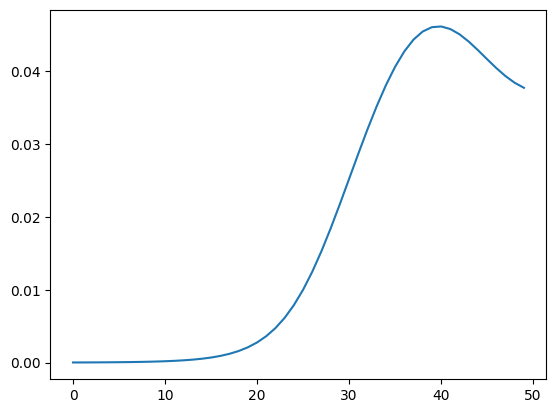

In [24]:
plt.plot(data['pi'][1,3,:])